# Task 8: Fake news prediction
- The Fake News Prediction Dataset features both real and fake news, providing a
basis for predictive modeling to identify misinformation. With columns including Title, Text, and Label (Fake or Real), it addresses the pervasive issue of false or
misleading information in news.
- The dataset supports efforts to enhance information integrity, combat fake news,
and promote media literacy.

# Fake news dataset information

Fake news or hoax news is false or misleading information presented as news. Fake news often has the aim of damaging the reputation of a person or entity, or making money through advertising revenue.

This dataset is having Both Fake and Real news.

The columns present in the dataset are:-

1) `Title` -> Title of the News

2) `Text` -> Text or Content of the News

3) `Label` -> Labelling the news as Fake or Real

In [1]:
# Necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neattext.functions as nfx
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, log_loss, matthews_corrcoef
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from ydata_profiling import ProfileReport
from warnings import filterwarnings
from wordcloud import WordCloud

filterwarnings('ignore')
%matplotlib inline

In [2]:

# # Read the data as a pandas dataframe
df = pd.read_csv("C:/Ankit/Dataset/CognoRise_Infotech/data/raw/news.csv")
df.drop('Unnamed: 0', axis=1, inplace=True) # Dropping useless index column

# EDA, (Exploratory data analysis)

From the analysis of the description dataframe we can see that unique `title` and `text` are less than the total amount of data, meaning some news are duplicated, I will procced to eliminate those repeated new just by grabbing the unique ones from the `text` column.

In [4]:
print(f'Description before duplicates: {df.describe()}')
print('\n\n')

# Assuming 'df' is your DataFrame
df = df.copy().drop_duplicates(subset=['text'])
print(f'Description after duplicates: {df.describe()}')

Description before duplicates:                                 title  \
count                            6335   
unique                           6256   
top     OnPolitics | 's politics blog   
freq                                5   

                                                     text label  
count                                                6335  6335  
unique                                               6060     2  
top     Killing Obama administration rules, dismantlin...  REAL  
freq                                                   58  3171  



Description after duplicates:                               title  \
count                          6060   
unique                         6011   
top     Michael Moore Owes Me $4.99   
freq                              3   

                                                     text label  
count                                                6060  6060  
unique                                               6060     2  
top   

From the first ProfileReport for EDA of the data without duplicated news we can conclude the following:

- The `label`, (fake or real news), is not imbalanced, there are reasonably a good number of samples for both labels.

- The most common words in both `title` and `text` columns are stopwords, it would be requiered that these are eliminated to not interfer in the real importance of the words to determine if a new is fake or not.

- There are not nulls in the data.

Overview of the dataset

In [6]:
df.head(3)

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL


Looking at the number of labels that there are and changing its values from 'REAL' and 'FAKE' to 0 and 1. This is done to enhance the model performance and make the variable more understandable for it.

In [7]:
print(f'Data by label: {df.label.value_counts()}')

# Treatment to change real for 0 and fake for 1
df.label = df.label.map({'REAL': 0, 'FAKE': 1})
print(df.label.unique())

Data by label: label
FAKE    3071
REAL    2989
Name: count, dtype: int64
[1 0]


# Text cleaning

Adding more columns to the data so the model has more information to predict

In [8]:
df['text_length'] = df['text'].apply(len)
df['text_num_capital_letters'] = df['text'].apply(lambda s: sum([1 for c in s if c.isupper()]))
df['text_num_words'] = df['text'].apply(lambda s: len(s.split()))
df['text_avg_word_length'] = df['text'].apply(lambda s: sum(len(word) for word in s.split()) / len(s.split()) if len(s.split()) > 0 else 0)
df['text_num_special_chars'] = df['text'].apply(lambda s: sum([1 for c in s if not c.isalnum() and not c.isspace()]))

df.head()

,title,text,label,text_length,text_num_capital_letters,text_num_words,text_avg_word_length,text_num_special_chars
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,7549,314,1296,4.776235,147
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,2654,96,446,4.917040,78
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,2559,96,431,4.883991,55
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,2673,139,404,5.554455,98
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,1860,77,317,4.776025,65


In [9]:
def clean_text(text) -> str:
    """
    Cleans the input text by performing the following operations:
    - Converts the text to lowercase
    - Removes special characters
    - Removes stopwords
    - Removes URLs
    - Removes punctuation
    - Removes email addresses
    - Removes user handles

    Parameters:
    text (str): The input text to be cleaned.

    Returns:
    str: The cleaned text.
    """
    text = str(text).lower()
    text = nfx.remove_special_characters(text)
    text = nfx.remove_stopwords(text)
    text = nfx.remove_urls(text)
    text = nfx.remove_puncts(text)
    text = nfx.remove_emails(text)
    text = nfx.remove_userhandles(text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df.drop(['text', 'title'], axis=1, inplace=True)
df.head()

,label,text_length,text_num_capital_letters,text_num_words,text_avg_word_length,text_num_special_chars,cleaned_text
0,1,7549,314,1296,4.776235,147,daniel greenfield shillman journalism fellow f...
1,1,2654,96,446,4.917040,78,google pinterest digg linkedin reddit stumbleu...
2,0,2559,96,431,4.883991,55,secretary state john f kerry said monday stop ...
3,1,2673,139,404,5.554455,98,kaydee king kaydeeking november 9 2016 lesson ...
4,0,1860,77,317,4.776025,65,primary day new york frontrunners hillary clin...


In [10]:
df.describe()

,label,text_length,text_num_capital_letters,text_num_words,text_avg_word_length,text_num_special_chars
count,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000,6060.000000
mean,0.506766,4907.623927,159.221617,805.143894,5.077739,145.642409
std,0.499995,5136.625560,178.245322,858.836623,0.718360,159.460259
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1971.500000,69.000000,324.000000,4.882522,55.000000
50%,1.000000,3855.500000,121.000000,631.000000,5.045942,111.000000
75%,1.000000,6349.000000,196.000000,1044.000000,5.215551,185.000000
max,1.000000,115848.000000,3891.000000,20891.000000,48.496000,3191.000000


From the ProfileReport of the dataframe at this point before making a machine learning, (ML), model it can be concluded the following:

- There are two variables, `cleaned_text` and `cleaned_title` that are the main predictors for our target variable `label`, these two variables have to be proccesed, specifically a vectorization so the ML model can understand the text data.

- Now, it can be seen that words as Said, Clinton, Trump and Obama are being constantly repeated based on the WordCloud graphs for the `cleaned_text` and `cleaned_title` variables.

# Model implementation

In [13]:
X = df.drop('label', axis=1) # Predictors
y = df['label'] # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # Splitting the data

Making a pipeline to do the following: 
- Vectorize both `cleaned_text` and `cleaned_title` variables so the model can understand them.
- Apply a RobustScaler to the numerical data so each column is in the same scale, with an enfasis in outliers.

In [14]:
# Preprocessing steps
preprocess = ColumnTransformer(
    transformers=[
        ('cleaned_text', TfidfVectorizer(), 'cleaned_text'),    # TfidfVectorizer for 'cleaned_text'
        ('numeric', RobustScaler(), df.columns.drop(['cleaned_text', 'label'])) # RobustScaler for numeric columns
    ]
)

# Model to use
model = RandomForestClassifier()

# Creating the pipeline
pipeline = Pipeline([
    ('preprocess', preprocess), # Preprocessing
    ('classifier', model)       # Model
])

# Parameter grid to search best parameters
param_distributions = {
    'classifier__n_estimators': [100, 200, 300, 400, 500],  # Number of trees
    'classifier__max_depth': [10, 20, 30, 40, 50, 60, 100, 200],   # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],     # Minimum number of samples required to split an internal node
    'classifier__min_samples_leaf': [1, 2, 4],       # Minimum number of samples required at a leaf node
    'classifier__max_features': ['sqrt', 'log2'],    # The number of features to consider when looking for the best split
    'classifier__bootstrap': [True, False]           # Whether bootstrap samples are used when building trees
}

# RandomizedSearch to find the best parameters for our model and data
random_search = RandomizedSearchCV(pipeline, param_distributions, scoring='recall', cv=3, n_iter=10)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
print(f"Best parameters: {best_params}")

# Best model
best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

Best parameters: {'classifier__n_estimators': 400, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 4, 'classifier__max_features': 'log2', 'classifier__max_depth': 200, 'classifier__bootstrap': True}


Metrics and evaluation of the model

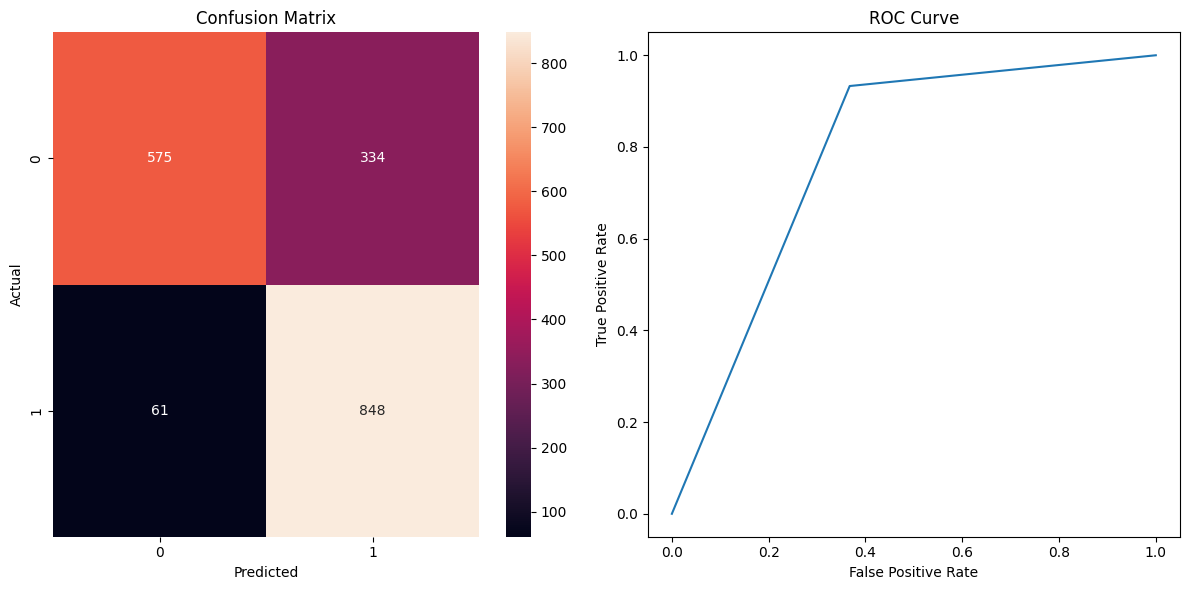

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', ax=ax1)
ax1.set_title('Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

# Plot ROC Curve
ax2.plot(fpr, tpr)
ax2.set_title('ROC Curve')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')

plt.tight_layout()
plt.show()

In [17]:
# Predictions on training set
train_predictions = best_model.predict(X_train)

# Classification report for training set
train_report = classification_report(y_train, train_predictions)
print(f"Training Classification Report:\n{train_report}\n")

# Classification report for testing set
test_report = classification_report(y_test, predictions)
print(f"Testing Classification Report:\n{test_report}")

Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.68      0.80      2080
           1       0.76      0.98      0.86      2162

    accuracy                           0.83      4242
   macro avg       0.87      0.83      0.83      4242
weighted avg       0.87      0.83      0.83      4242


Testing Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.63      0.74       909
           1       0.72      0.93      0.81       909

    accuracy                           0.78      1818
   macro avg       0.81      0.78      0.78      1818
weighted avg       0.81      0.78      0.78      1818



Learning curves for the models and four different metrics for classification

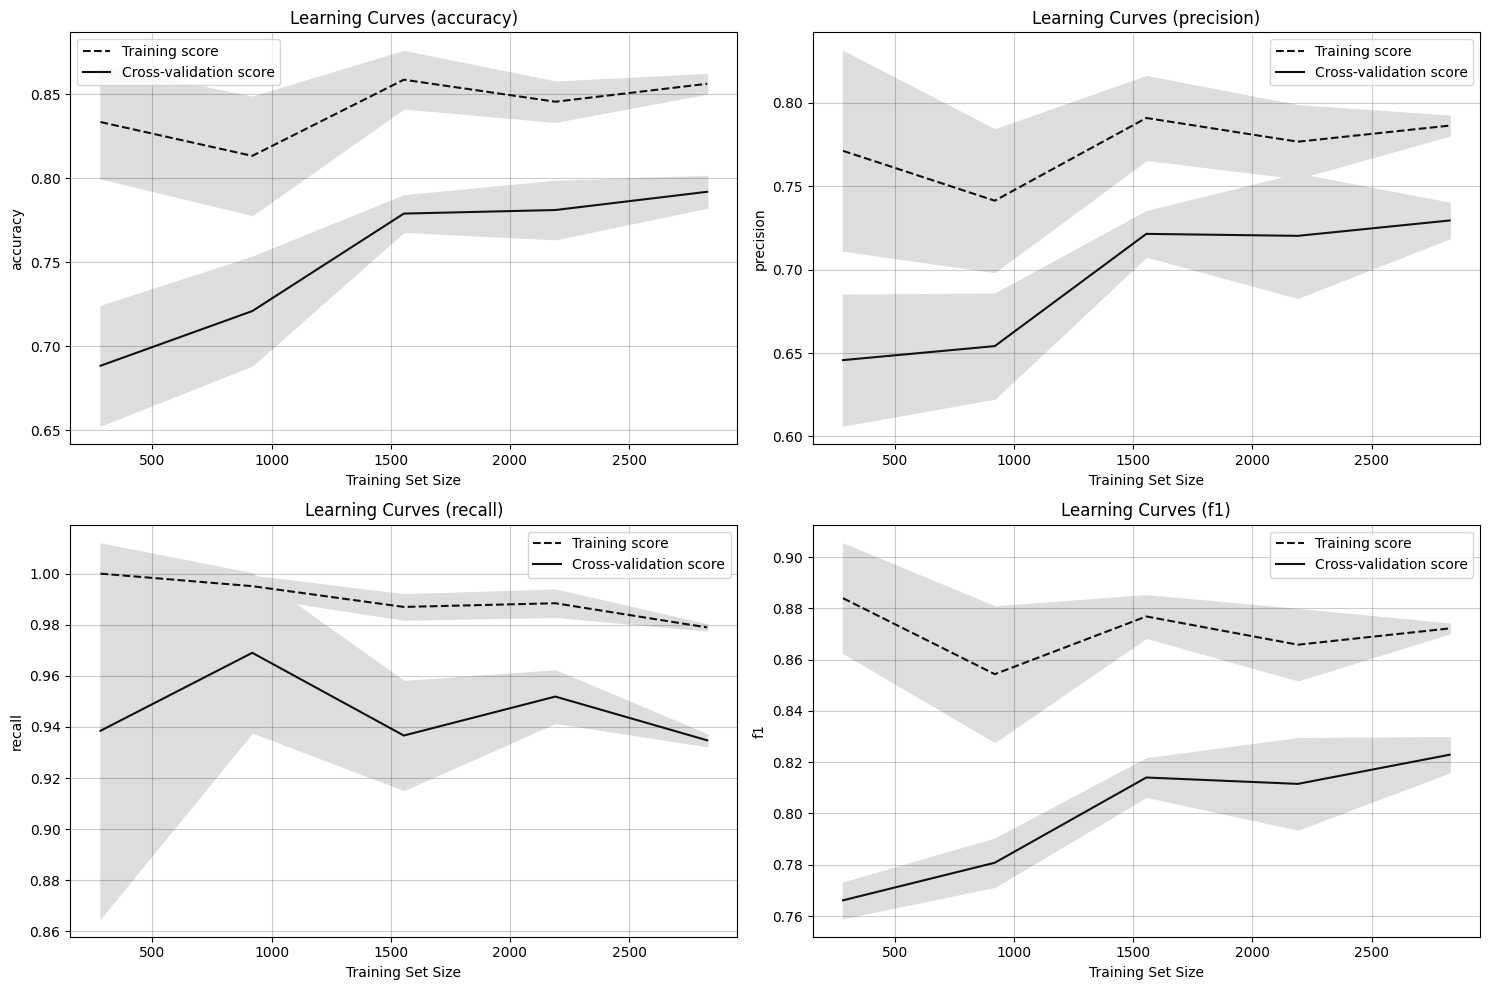

In [18]:
# Metrics to use for learning curves
metrics = ['accuracy', 'precision', 'recall', 'f1']

# Creating 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.ravel()  # Flattening the 2D array

# Plotting learning curves for each metric
for i, metric in enumerate(metrics):
    train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=3, scoring=metric)

    # Creating means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Creating means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    axs[i].plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    axs[i].plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    axs[i].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    axs[i].fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    axs[i].set_title(f'Learning Curves ({metric})')
    axs[i].set_xlabel('Training Set Size')
    axs[i].set_ylabel(metric)
    axs[i].legend(loc='best')
    axs[i].grid(True, alpha=0.2, color='black')

plt.tight_layout()
plt.show()

In [19]:
# AUC-ROC Score
auc_score = roc_auc_score(y_test, predictions)
print("AUC-ROC Score:", auc_score)

# Log Loss
log_loss_score = log_loss(y_test, predictions)
print("Log Loss:", log_loss_score)

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, predictions)
print("Matthews Correlation Coefficient:", mcc)

AUC-ROC Score: 0.7827282728272826
Log Loss: 7.831266825468248
Matthews Correlation Coefficient: 0.5928240621231636


The model performed well on the training set with an accuracy of 96%, demonstrating high precision and recall for both classes. However, its performance on the test set was slightly lower, with an accuracy of 83%. The model had a higher recall for class 1 (91%) compared to class 0 (75%) in the test set, indicating it was better at identifying true positives for class 1. Overall, the model showed good performance.

The AUC-ROC Score of 0.7827 indicates that the model has a good measure of separability, and it is capable of distinguishing between positive and negative classes. 

The Log Loss of 7.831 is quite high. Log Loss quantifies the accuracy of a classifier by penalising false classifications. Minimising Log Loss is basically equivalent to maximising the accuracy of the classifier, but there is a strong penalty for being confident and wrong. In this case, the model might have made some confident, but incorrect predictions.

In general, the model seems to perform well, but there might be room for improvement, especially in reducing the Log Loss.

The Matthews Correlation Coefficient (MCC) of 0.5928 indicates a moderate correlation between the observed and predicted binary classifications. The MCC is considered a balanced measure since it can be used even if the classes are of very different sizes. A perfect classifier would have an MCC of 1. 